In [1]:
import jax
import jax.numpy as jnp
import jax.random as random

import numpy as np

import optax
from flax.training.train_state import TrainState

from models import AutoEncoder
from data_generator import SimplePendulum, get_batched_data

import matplotlib.pyplot as plt

/Users/sahel/Code/latent_space_estimation/env/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


## Visualize the training data

In [2]:
# Load the data
key = random.PRNGKey(5)
key, subkey = random.split(key)
pend = SimplePendulum()
trajectory = pend.get_trajectory(subkey)
train_data = trajectory.T
polar_coords = train_data[:, :2]
cart_coords = train_data[:, 2:]
time_steps = jnp.linspace(0., 10., train_data.shape[0])

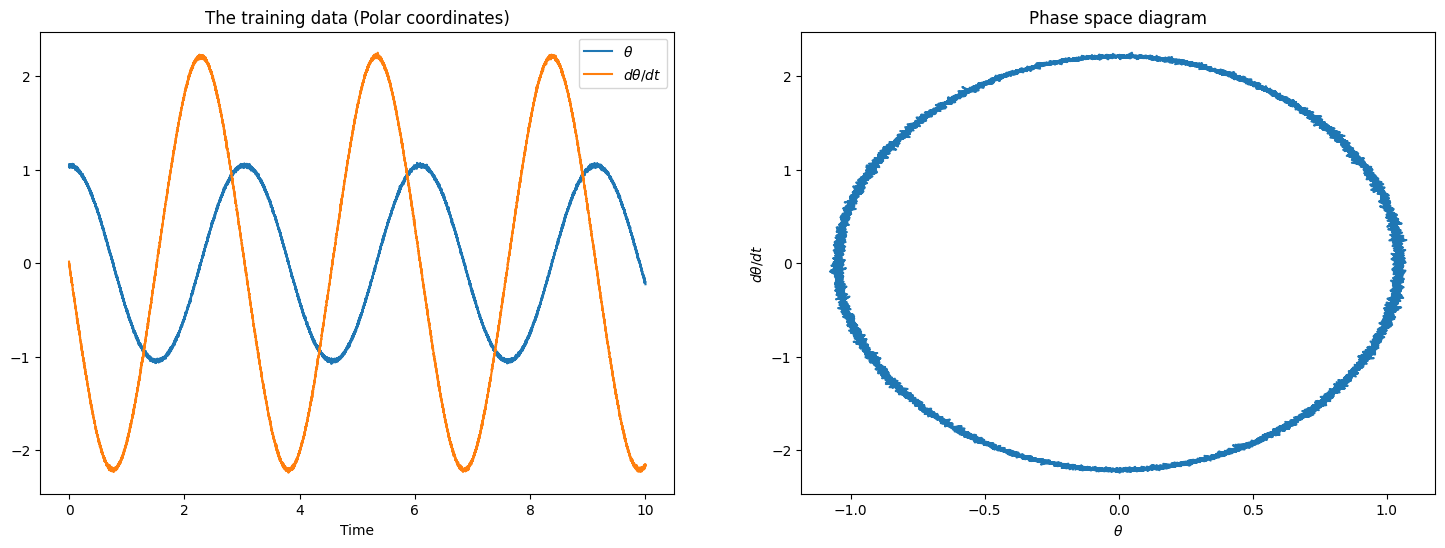

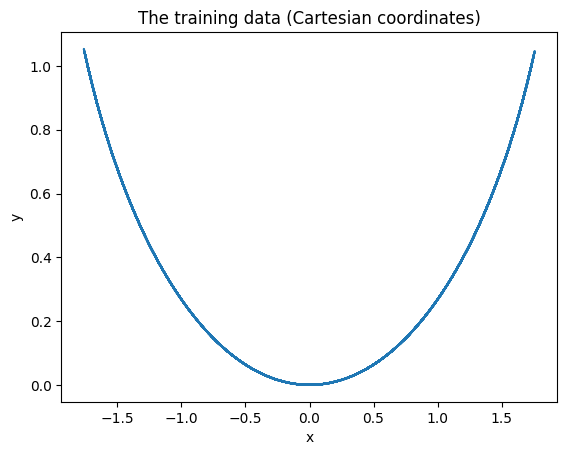

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
ax1.plot(time_steps, polar_coords[:, 0], label=r'$\theta$')
ax1.plot(time_steps, polar_coords[:, 1], label=r'$d\theta/dt$')
ax1.legend()
ax1.set_xlabel("Time")
ax1.set_title("The training data (Polar coordinates)")

ax2.plot(polar_coords[:, 0], polar_coords[:, 1])
ax2.set_xlabel(r"$\theta$")
ax2.set_ylabel(r"$d\theta/dt$")
ax2.set_title("Phase space diagram")
plt.show()

plt.figure()
plt.plot(cart_coords[:, 0], cart_coords[:, 1])
plt.xlabel(r"x")
plt.ylabel(r"y")
plt.title("The training data (Cartesian coordinates)")
plt.show()

## Train the model

In [4]:
# 0. Initialize hyperparameters
num_epochs = 250
batch_size = 32
encoder_widths = [128, 64, 32, 16, 1]
decoder_widths = [1, 16, 32, 64, 128]
learning_rate = 1e-3

In [5]:
# 1. Get the data
batched_data, num_batches = get_batched_data(subkey, train_data, batch_size)

# 2. Define and initialize the model
input_shape = (2,)  # (x, y) is the input to the encoder.
model = AutoEncoder(encoder_widths,
                    decoder_widths,
                    input_shape)

init_data = jnp.ones((batch_size, *input_shape))
key, subkey = random.split(key)
variables = model.init(random.PRNGKey(0), init_data)

# Create the train state
key, subkey = random.split(key)
state = TrainState.create(
    apply_fn=model.apply,
    params=model.init(subkey, init_data)['params'],
    tx=optax.adam(learning_rate),
)


# 3. Define the loss function
def recon_loss(model, params, batched_x):
    """
    Returns the reconstruction loss for batched data.
    It is a mean squared error implementation.
    """
    def recon_loss_single(x):
        """
        The reconstruction loss for a single datapoint x.
        """
        # Separate the position and momentum coordinates.
        q, p = x[2:4], x[4:]

        # Define separate functions for the encoder and the decoder.
        a = lambda input_q: model.apply({'params': params}, input_q, method=model.encode)
        b = lambda input_z: model.apply({'params': params}, input_z, method=model.decode)

        # Reconstruct the position coordinates by passing through the autoencoder.
        z = a(q)
        q_hat = b(z)

        # Reconstruct the momentum coordinates using the equations.
        grad_a = jax.jacfwd(a)(q).squeeze()
        dzdt = jnp.dot(grad_a, p)

        jac_b = jax.jacfwd(b)(z).squeeze()
        p_hat = dzdt * jac_b
        x_hat = jnp.concatenate([q_hat, p_hat])
        loss = jnp.sum(jnp.square(x[2:] - x_hat))
        return loss

    return jnp.mean(jax.vmap(recon_loss_single)(batched_x))


# 4. Write the training loop.
@jax.jit
def train_step(state, batch):
    """
    Train for a single step/batch.
    """
    grad_fn = jax.value_and_grad(recon_loss, argnums=1)
    loss, grads = grad_fn(model, state.params, batch)
    state = state.apply_gradients(grads=grads)
    return state, loss


# 5. Train the model.
for epoch in range(num_epochs):
    epoch_loss = 0.
    for i in range(num_batches):
        batch = batched_data[i]
        state, loss = train_step(state, batch)
        epoch_loss += loss

    epoch_loss /= num_batches

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss = {epoch_loss}")

Epoch 0 - Loss = 5.749363422393799
Epoch 10 - Loss = 4.275596618652344
Epoch 20 - Loss = 4.265460968017578
Epoch 30 - Loss = 4.259426593780518
Epoch 40 - Loss = 4.252795696258545
Epoch 50 - Loss = 4.258570194244385
Epoch 60 - Loss = 4.249702453613281
Epoch 70 - Loss = 4.246450901031494
Epoch 80 - Loss = 4.241912841796875
Epoch 90 - Loss = 4.241508960723877
Epoch 100 - Loss = 4.2397990226745605
Epoch 110 - Loss = 4.241246223449707
Epoch 120 - Loss = 4.239058494567871
Epoch 130 - Loss = 4.235121250152588
Epoch 140 - Loss = 4.232237815856934
Epoch 150 - Loss = 4.230637550354004
Epoch 160 - Loss = 4.229360103607178
Epoch 170 - Loss = 4.22851037979126
Epoch 180 - Loss = 4.227348804473877
Epoch 190 - Loss = 4.226215362548828
Epoch 200 - Loss = 4.224638938903809
Epoch 210 - Loss = 4.223505020141602
Epoch 220 - Loss = 4.222956657409668
Epoch 230 - Loss = 4.2216477394104
Epoch 240 - Loss = 4.221102714538574


In [6]:
def predict_latent_batched(model, params, batched_x):
    def predict_latent_single(x):
        """
        Predict the latent space of a single data point.
        """
        # Separate the position and momentum coordinates.
        q, p = x[2:4], x[4:]

        # Define separate functions for the encoder and the decoder.
        a = lambda input_q: model.apply({'params': params}, input_q, method=model.encode)

        # Reconstruct the position coordinates by passing through the autoencoder.
        z = a(q)

        # Reconstruct the momentum coordinates using the equations.
        grad_a = jax.jacfwd(a)(q).squeeze()
        dzdt = jnp.dot(grad_a, p)

        return z, dzdt

    return jax.vmap(predict_latent_single)(batched_x)


def get_latent_variables(model, state, batched_input):
    """
    Function to get the latent variables predicted by the model.
    :param state: The train state of the trained model.
    :param batched_input: Batched input data (unshuffled).
    :return: (z, dz/dt) (2, time_steps)
    """
    z_list = []
    dzdt_list = []
    for i in range(num_batches):
        batch = batched_input[i]
        z, dzdt = predict_latent_batched(model, state.params, batch)
        z_list.append(z)
        dzdt_list.append(dzdt)

    z = np.concatenate(z_list, axis=0).squeeze()
    dzdt = np.concatenate(dzdt_list, axis=0)
    latent_variables = np.stack((z, dzdt), axis=0)
    return latent_variables

In [7]:
test_data, num_batches = get_batched_data(key, train_data, batch_size, permute=False)
latent_variables = get_latent_variables(model, state, test_data)

## Visualize the latent space predicted by the model.

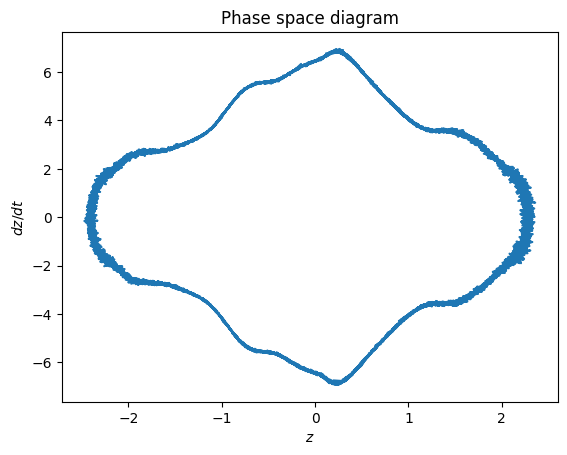

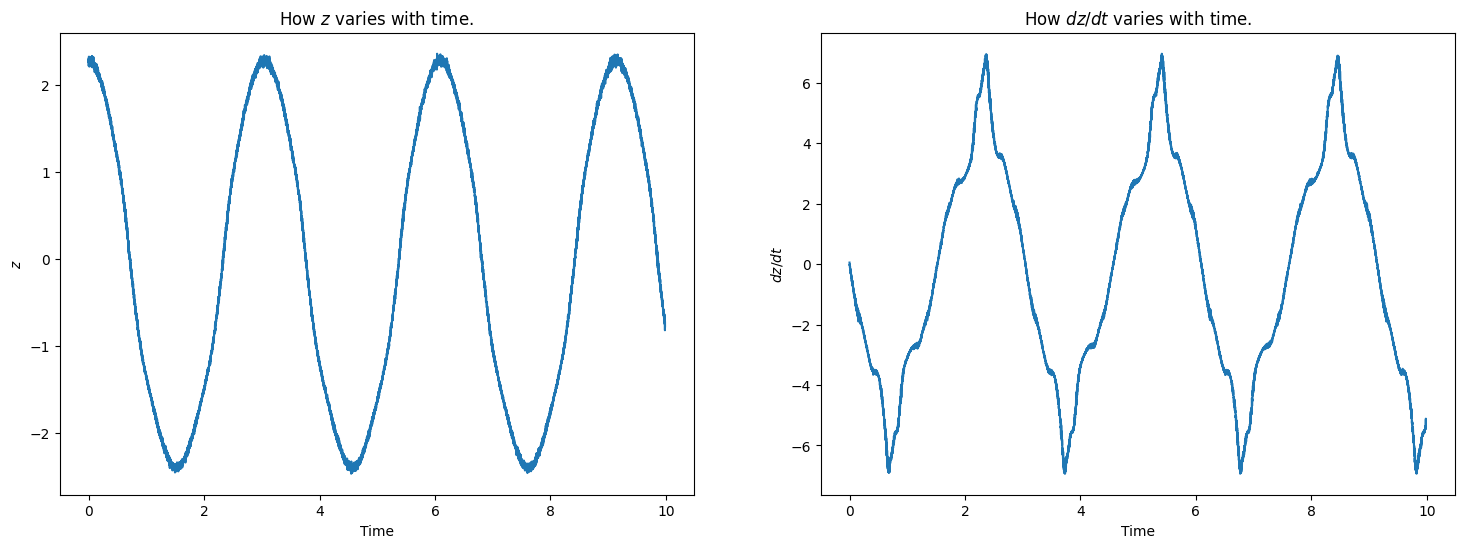

In [8]:
plt.figure()
plt.plot(latent_variables[0], latent_variables[1])
plt.xlabel(r"$z$")
plt.ylabel(r"$dz/dt$")
plt.title("Phase space diagram")
plt.show()

num_time_steps = latent_variables.shape[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
ax1.plot(time_steps[:num_time_steps], latent_variables[0])
ax1.set_ylabel(r"$z$")
ax1.set_xlabel("Time")
ax1.set_title(r"How $z$ varies with time.")

ax2.plot(time_steps[:num_time_steps], latent_variables[1])
ax2.set_ylabel(r"$dz/dt$")
ax2.set_xlabel("Time")
ax2.set_title(r"How $dz/dt$ varies with time.")
plt.show()